## Imports

In [1]:
import math
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

## Input

In [3]:
crc_df = pd.read_csv('Data/CRC_2016to2020_comprehensive.csv')
lca_df = pd.read_csv('Data/LCa_2016to2020_comprehensive.csv')

In [4]:
# this is to only select patients matching exclusion criteria, as the comprehensive dataset also contains the others
crc_df = crc_df[crc_df['HasPCPAfterCutOff'] == 1]
lca_df = lca_df[lca_df['HasPCPAfterCutOff'] == 1]

## CRC Sta3n Histogram

In [5]:
crc_numep_df = crc_df[['DiagnosisSta3n', 'EP']].groupby('DiagnosisSta3n').sum()
crc_numep_df = crc_numep_df.rename(columns={'EP':'num_EPs'})

In [6]:
crc_numdx_df = crc_df[['DiagnosisSta3n', 'EP']].groupby('DiagnosisSta3n').count()
crc_numdx_df = crc_numdx_df.rename(columns={'EP':'tot_dx'})

In [7]:
crc_epratio_df = crc_numep_df.merge(crc_numdx_df,left_on='DiagnosisSta3n',right_on='DiagnosisSta3n')
crc_epratio_df['ratio'] = (crc_epratio_df['num_EPs'] / crc_epratio_df['tot_dx']) * 100
crc_epratio_df['ratio'].describe()

count    117.000000
mean      22.868788
std       11.104877
min        0.000000
25%       18.181818
50%       23.376623
75%       27.619048
max      100.000000
Name: ratio, dtype: float64

(0.0, 100.0)

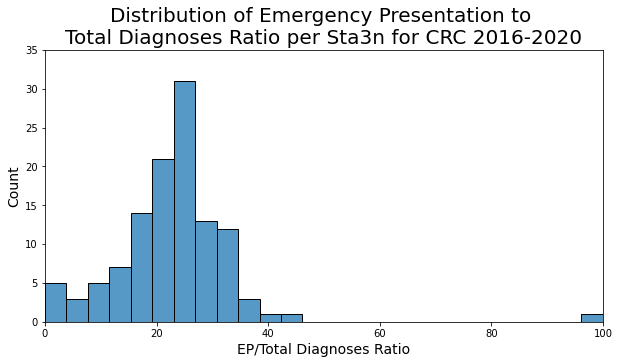

In [8]:
crc_hist_plt = sns.histplot(data=crc_epratio_df['ratio'])
crc_hist_plt.axes.set_title("Distribution of Emergency Presentation to \nTotal Diagnoses Ratio per Sta3n for CRC 2016-2020", fontsize=20)
crc_hist_plt.axes.set_xlabel ("EP/Total Diagnoses Ratio", fontsize=14)
crc_hist_plt.axes.set_ylabel ("Count", fontsize=14)
crc_hist_plt.axes.set_ylim ([0, 35])
crc_hist_plt.axes.set_xlim ([0, 100])

## Lung Cancer Sta3n Histogram

In [9]:
lca_numep_df = lca_df[['DiagnosisSta3n', 'EP']].groupby('DiagnosisSta3n').sum()
lca_numep_df = lca_numep_df.rename(columns={'EP':'num_EPs'})

In [10]:
lca_numdx_df = lca_df[['DiagnosisSta3n', 'EP']].groupby('DiagnosisSta3n').count()
lca_numdx_df = lca_numdx_df.rename(columns={'EP':'tot_dx'})

In [11]:
lca_epratio_df = lca_numep_df.merge(lca_numdx_df,left_on='DiagnosisSta3n',right_on='DiagnosisSta3n')
lca_epratio_df['ratio'] = (lca_epratio_df['num_EPs'] / lca_epratio_df['tot_dx']) * 100
lca_epratio_df['ratio'].describe()

count    120.000000
mean      21.658974
std        8.663437
min        0.000000
25%       17.331723
50%       21.763654
75%       24.971109
max       66.666667
Name: ratio, dtype: float64

(0.0, 100.0)

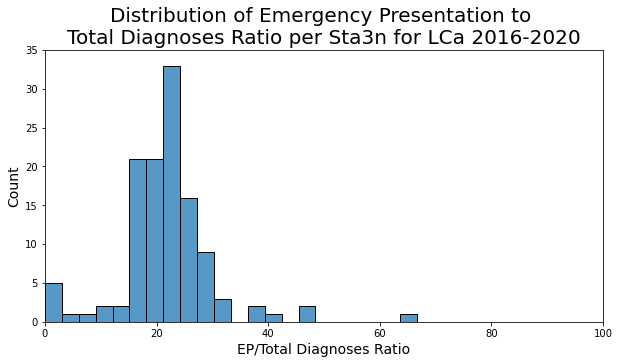

In [12]:
lca_hist_plt = sns.histplot(data=lca_epratio_df['ratio'])
lca_hist_plt.axes.set_title("Distribution of Emergency Presentation to \nTotal Diagnoses Ratio per Sta3n for LCa 2016-2020", fontsize=20)
lca_hist_plt.axes.set_xlabel ("EP/Total Diagnoses Ratio", fontsize=14)
lca_hist_plt.axes.set_ylabel ("Count", fontsize=14)
lca_hist_plt.axes.set_ylim ([0, 35])
lca_hist_plt.axes.set_xlim ([0, 100])

## EP Incidence Tables

### Data Prep

In [13]:
def num_to_race (row):
    if (row['PatientRace'] == 1):
        return 'Black'
    elif (row['PatientRace'] == 2):
        return 'Hispanic'
    elif (row['PatientRace'] == 3):
        return 'White'
    elif (row['PatientRace'] == 4):
        return 'Other'
    return "ERROR"

In [14]:
def num_to_sex (row):
    if (row['PatientSex'] == 0):
        return 'Female'
    elif (row['PatientSex'] == 1):
        return 'Male'
    return "ERROR"

In [15]:
def num_to_pcp (row):
    if (row['HasPCPAfterCutOff'] == 0):
        return 'No PCP'
    elif (row['HasPCPAfterCutOff'] == 1):
        return 'Has PCP'
    return "ERROR"

In [17]:
crc_df_comp = pd.read_csv('Data/CRC_2016to2020_comprehensive.csv')

crc_df['PatientRaceString'] = crc_df.apply(lambda row: num_to_race(row), axis=1)
crc_df['PatientRaceString'] = pd.Categorical(crc_df['PatientRaceString'], categories=['Black', 'Hispanic', 'White', 'Other'], ordered=True)
crc_df['PatientSexString'] = crc_df.apply(lambda row: num_to_sex(row), axis=1)
crc_df['PatientSexString'] = pd.Categorical(crc_df['PatientSexString'], categories=['Male', 'Female'], ordered=True)

In [18]:
lca_df_comp = pd.read_csv('Data/LCa_2016to2020_comprehensive.csv')

lca_df['PatientRaceString'] = lca_df.apply(lambda row: num_to_race(row), axis=1)
lca_df['PatientRaceString'] = pd.Categorical(lca_df['PatientRaceString'], categories=['Black', 'Hispanic', 'White', 'Other'], ordered=True)
lca_df['PatientSexString'] = lca_df.apply(lambda row: num_to_sex(row), axis=1)
lca_df['PatientSexString'] = pd.Categorical(lca_df['PatientSexString'], categories=['Male', 'Female'], ordered=True)
lca_df['PCP'] = lca_df.apply(lambda row: num_to_pcp(row), axis=1)
lca_df['PCP'] = pd.Categorical(lca_df['PCP'], categories=['Has PCP', 'No PCP'], ordered=True)

### CRC

In [19]:
crc_stats_race = crc_df.groupby(['PatientRaceString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in crc_stats_race.index:
    m, s, c = crc_stats_race.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
crc_stats_race['ci95_hi'] = ci95_hi
crc_stats_race['ci95_lo'] = ci95_lo
crc_stats_race['% EP'] = crc_stats_race['mean'] * 100

In [20]:
crc_stats_race[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientRaceString,,,
Black,23.685984,25.215821,22.156147
Hispanic,27.241379,30.201456,24.281303
White,22.599149,23.414416,21.783883
Other,24.275862,27.399001,21.152723


Text(0, 0.5, 'Patient Race')

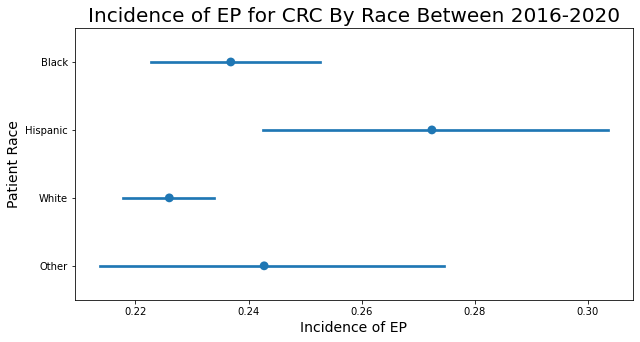

In [21]:
crc_stats_race_plot = sns.pointplot(data=crc_df, y='PatientRaceString', x='EP', orient='h', dodge=True, join=False)
crc_stats_race_plot.axes.set_title("Incidence of EP for CRC By Race Between 2016-2020", fontsize=20)
crc_stats_race_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
crc_stats_race_plot.axes.set_ylabel("Patient Race", fontsize=14)

In [22]:
crc_stats_sex = crc_df.groupby(['PatientSexString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in crc_stats_sex.index:
    m, s, c = crc_stats_sex.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
crc_stats_sex['ci95_hi'] = ci95_hi
crc_stats_sex['ci95_lo'] = ci95_lo
crc_stats_sex['% EP'] = crc_stats_sex['mean'] * 100

In [23]:
crc_stats_sex[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientSexString,,,
Male,23.296625,23.995020,22.598230
Female,20.367279,23.595162,17.139396


Text(0, 0.5, 'Patient Sex')

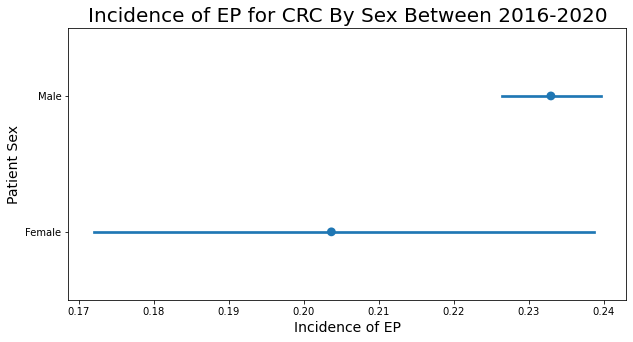

In [24]:
crc_stats_sex_plot = sns.pointplot(data=crc_df, y='PatientSexString', x='EP', orient='h', dodge=True, join=False)
crc_stats_sex_plot.axes.set_title("Incidence of EP for CRC By Sex Between 2016-2020", fontsize=20)
crc_stats_sex_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
crc_stats_sex_plot.axes.set_ylabel("Patient Sex", fontsize=14)

In [25]:
crc_df['PatientAge'].describe()

count    14674.000000
mean        68.621371
std         11.117693
min         24.000000
25%         63.000000
50%         69.000000
75%         75.000000
max        103.000000
Name: PatientAge, dtype: float64

In [26]:
crc_df['PatientAgeBinned'] = pd.cut(crc_df['PatientAge'], bins=[0, 64, 69, 75, 110])

crc_stats_age = crc_df.groupby(['PatientAgeBinned'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in crc_stats_age.index:
    m, s, c = crc_stats_age.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
crc_stats_age['ci95_hi'] = ci95_hi
crc_stats_age['ci95_lo'] = ci95_lo
crc_stats_age['% EP'] = crc_stats_age['mean'] * 100

In [27]:
crc_stats_age[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientAgeBinned,,,
"(0, 64]",21.088889,22.280938,19.896840
"(64, 69]",19.561607,20.978728,18.144487
"(69, 75]",20.483528,21.773024,19.194032
"(75, 110]",32.127096,33.697200,30.556993


Text(0, 0.5, 'Patient Age')

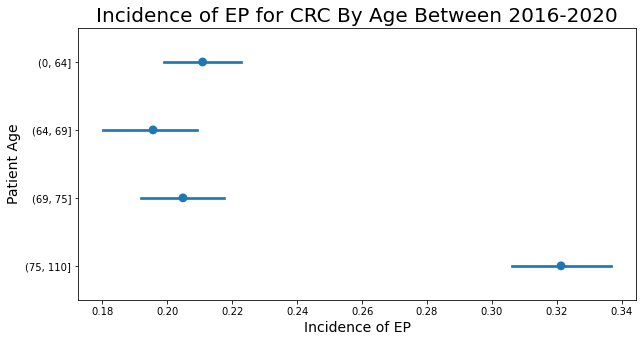

In [28]:
crc_stats_age_plot = sns.pointplot(data=crc_df, y='PatientAgeBinned', x='EP', orient='h', dodge=True, join=False)
crc_stats_age_plot.axes.set_title("Incidence of EP for CRC By Age Between 2016-2020", fontsize=20)
crc_stats_age_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
crc_stats_age_plot.axes.set_ylabel("Patient Age", fontsize=14)

In [29]:
crc_df_comp['PCP'] = crc_df_comp.apply(lambda row: num_to_pcp(row), axis=1)
crc_df_comp['PCP'] = pd.Categorical(crc_df_comp['PCP'], categories=['Has PCP', 'No PCP'], ordered=True)

crc_df_comp['PatientRaceString'] = crc_df_comp.apply(lambda row: num_to_race(row), axis=1)
crc_df_comp['PatientRaceString'] = pd.Categorical(crc_df_comp['PatientRaceString'], categories=['Black', 'Hispanic', 'White', 'Other'], ordered=True)

In [30]:
crc_stats_PCP = crc_df_comp.groupby(['PCP'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in crc_stats_PCP.index:
    m, s, c = crc_stats_PCP.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
crc_stats_PCP['ci95_hi'] = ci95_hi
crc_stats_PCP['ci95_lo'] = ci95_lo
crc_stats_PCP['% EP'] = crc_stats_PCP['mean'] * 100

In [31]:
crc_stats_PCP[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PCP,,,
Has PCP,23.177048,23.859813,22.494283
No PCP,53.164557,64.238625,42.090489


Text(0, 0.5, 'PCP Encounters Prior to Diagnosis')

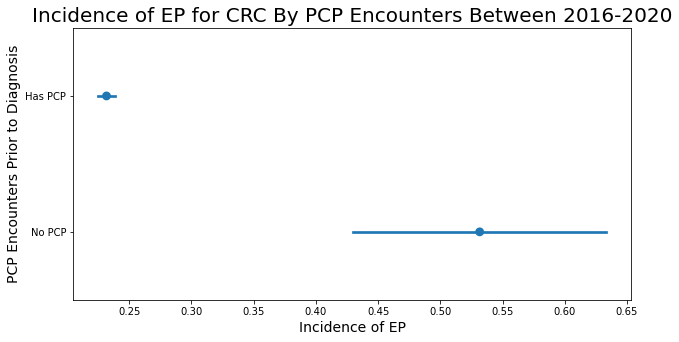

In [32]:
crc_stats_pcp_plot = sns.pointplot(data=crc_df_comp, y='PCP', x='EP', orient='h', dodge=True, join=False)
crc_stats_pcp_plot.axes.set_title("Incidence of EP for CRC By PCP Encounters Between 2016-2020", fontsize=20)
crc_stats_pcp_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
crc_stats_pcp_plot.axes.set_ylabel("PCP Encounters Prior to Diagnosis", fontsize=14)

In [33]:
crc_df_noex = crc_df_comp[crc_df_comp['HasPCPAfterCutOff']==0]

In [34]:
crc_stats_race_noex = crc_df_noex.groupby(['PatientRaceString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in crc_stats_race_noex.index:
    m, s, c = crc_stats_race_noex.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
crc_stats_race_noex['ci95_hi'] = ci95_hi
crc_stats_race_noex['ci95_lo'] = ci95_lo
crc_stats_race_noex['% EP'] = crc_stats_race_noex['mean'] * 100

In [35]:
crc_stats_race_noex

,mean,std,count,ci95_hi,ci95_lo,% EP
PatientRaceString,,,,,,
Black,0.785714,0.425815,14,100.876999,56.265858,78.571429
Hispanic,0.400000,0.547723,5,88.009999,-8.009999,40.000000
White,0.481481,0.504349,54,61.600248,34.696049,48.148148
Other,0.500000,0.547723,6,93.826932,6.173068,50.000000


In [36]:
crc_stats_race_noex[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientRaceString,,,
Black,78.571429,100.876999,56.265858
Hispanic,40.000000,88.009999,-8.009999
White,48.148148,61.600248,34.696049
Other,50.000000,93.826932,6.173068


### Lung Cancer

In [39]:
lca_stats_race = lca_df.groupby(['PatientRaceString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in lca_stats_race.index:
    m, s, c = lca_stats_race.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
lca_stats_race['ci95_hi'] = ci95_hi
lca_stats_race['ci95_lo'] = ci95_lo
lca_stats_race['% EP'] = lca_stats_race['mean'] * 100

In [40]:
lca_stats_race[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientRaceString,,,
Black,26.396761,27.496264,25.297258
Hispanic,27.800830,30.630514,24.971146
White,20.076700,20.538195,19.615205
Other,20.460199,22.432600,18.487798


Text(0, 0.5, 'Patient Race')

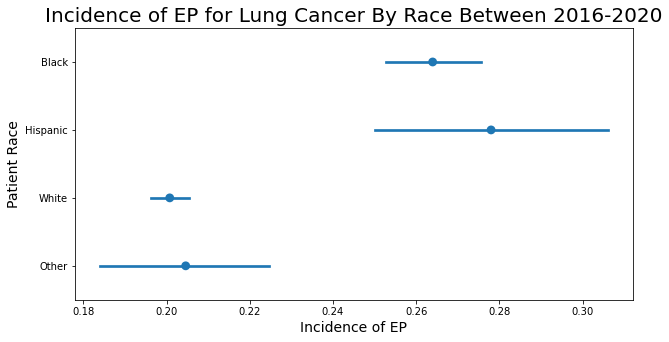

In [41]:
lca_stats_race_plot = sns.pointplot(data=lca_df, y='PatientRaceString', x='EP', orient='h', dodge=True, join=False)
lca_stats_race_plot.axes.set_title("Incidence of EP for Lung Cancer By Race Between 2016-2020", fontsize=20)
lca_stats_race_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
lca_stats_race_plot.axes.set_ylabel("Patient Race", fontsize=14)

In [42]:
lca_stats_sex = lca_df.groupby(['PatientSexString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in lca_stats_sex.index:
    m, s, c = lca_stats_sex.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
lca_stats_sex['ci95_hi'] = ci95_hi
lca_stats_sex['ci95_lo'] = ci95_lo
lca_stats_sex['% EP'] = lca_stats_sex['mean'] * 100

In [46]:
lca_stats_sex

,mean,std,count,ci95_hi,ci95_lo,% EP
PatientSexString,,,,,,
Male,0.213846,0.410025,36358,21.806034,20.963095,21.384565
Female,0.197299,0.398110,1333,21.867125,17.592740,19.729932


In [43]:
lca_stats_sex[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientSexString,,,
Male,21.384565,21.806034,20.963095
Female,19.729932,21.867125,17.592740


Text(0, 0.5, 'Patient Sex')

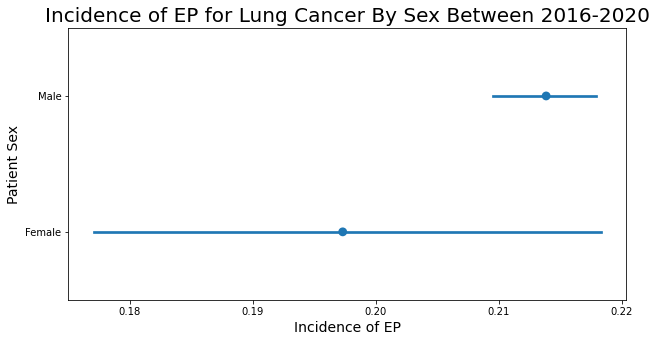

In [45]:
lca_stats_sex_plot = sns.pointplot(data=lca_df, y='PatientSexString', x='EP', orient='h', dodge=True, join=False)
lca_stats_sex_plot.axes.set_title("Incidence of EP for Lung Cancer By Sex Between 2016-2020", fontsize=20)
lca_stats_sex_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
lca_stats_sex_plot.axes.set_ylabel("Patient Sex", fontsize=14)

In [47]:
lca_df['PatientAge'].describe()

count    37691.000000
mean        70.813536
std          7.994518
min         25.000000
25%         66.000000
50%         70.000000
75%         75.000000
max        103.000000
Name: PatientAge, dtype: float64

In [48]:
lca_df['PatientAgeBinned'] = pd.cut(lca_df['PatientAge'], bins=[0, 66, 70, 75, 110])

lca_stats_age = lca_df.groupby(['PatientAgeBinned'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in lca_stats_age.index:
    m, s, c = lca_stats_age.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
lca_stats_age['ci95_hi'] = ci95_hi
lca_stats_age['ci95_lo'] = ci95_lo
lca_stats_age['% EP'] = lca_stats_age['mean'] * 100

In [50]:
lca_stats_age[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientAgeBinned,,,
"(0, 66]",23.570020,24.396192,22.743848
"(66, 70]",19.511649,20.333734,18.689564
"(70, 75]",19.796798,20.588029,19.005567
"(75, 110]",22.266021,23.131438,21.400604


Text(0, 0.5, 'Patient Age')

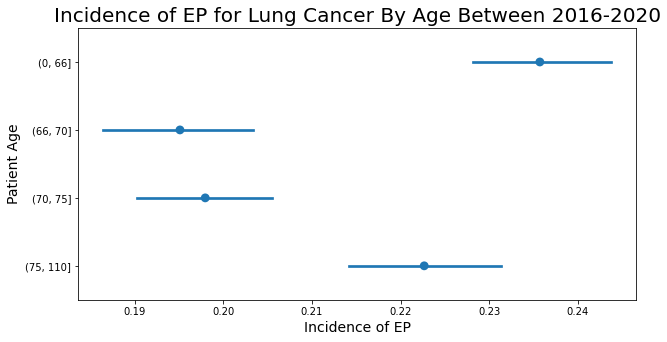

In [58]:
lca_stats_age_plot = sns.pointplot(data=lca_df, y='PatientAgeBinned', x='EP', orient='h', dodge=True, join=False)
lca_stats_age_plot.axes.set_title("Incidence of EP for Lung Cancer By Age Between 2016-2020", fontsize=20)
lca_stats_age_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
lca_stats_age_plot.axes.set_ylabel("Patient Age", fontsize=14)

In [52]:
lca_df_comp['PCP'] = lca_df_comp.apply(lambda row: num_to_pcp(row), axis=1)
lca_df_comp['PCP'] = pd.Categorical(lca_df_comp['PCP'], categories=['Has PCP', 'No PCP'], ordered=True)

lca_df_comp['PatientRaceString'] = lca_df_comp.apply(lambda row: num_to_race(row), axis=1)
lca_df_comp['PatientRaceString'] = pd.Categorical(lca_df_comp['PatientRaceString'], categories=['Black', 'Hispanic', 'White', 'Other'], ordered=True)

In [55]:
lca_stats_PCP = lca_df_comp.groupby(['PCP'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in lca_stats_PCP.index:
    m, s, c = lca_stats_PCP.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
lca_stats_PCP['ci95_hi'] = ci95_hi
lca_stats_PCP['ci95_lo'] = ci95_lo
lca_stats_PCP['% EP'] = lca_stats_PCP['mean'] * 100

In [56]:
lca_stats_PCP[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PCP,,,
Has PCP,21.326046,21.739582,20.912510
No PCP,30.620155,36.255362,24.984948


Text(0, 0.5, 'PCP Encounters Prior to Diagnosis')

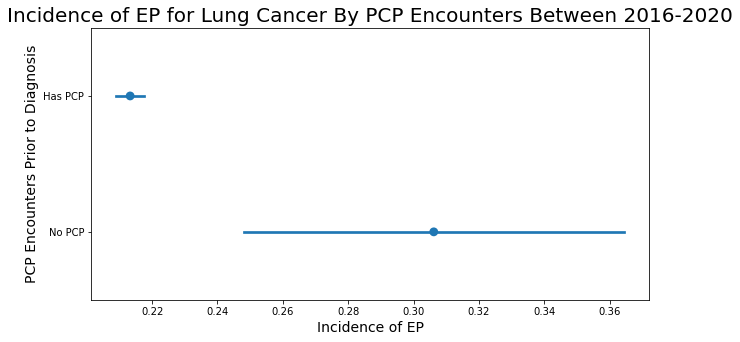

In [57]:
lca_stats_pcp_plot = sns.pointplot(data=lca_df_comp, y='PCP', x='EP', orient='h', dodge=True, join=False)
lca_stats_pcp_plot.axes.set_title("Incidence of EP for Lung Cancer By PCP Encounters Between 2016-2020", fontsize=20)
lca_stats_pcp_plot.axes.set_xlabel("Incidence of EP", fontsize=14)
lca_stats_pcp_plot.axes.set_ylabel("PCP Encounters Prior to Diagnosis", fontsize=14)

In [59]:
lca_df_noex = lca_df_comp[lca_df_comp['HasPCPAfterCutOff']==0]

In [63]:
lca_stats_race_noex = lca_df_noex.groupby(['PatientRaceString'])['EP'].agg(['mean', 'std', 'count'])

ci95_hi = []
ci95_lo = []

for i in lca_stats_race_noex.index:
    m, s, c = lca_stats_race_noex.loc[i]
    ci95_hi.append((m + 1.96 * s/math.sqrt(c)) * 100)
    ci95_lo.append((m - 1.96 * s/math.sqrt(c)) * 100)
    
lca_stats_race_noex['ci95_hi'] = ci95_hi
lca_stats_race_noex['ci95_lo'] = ci95_lo
lca_stats_race_noex['% EP'] = lca_stats_race_noex['mean'] * 100

In [64]:
lca_stats_race_noex

,mean,std,count,ci95_hi,ci95_lo,% EP
PatientRaceString,,,,,,
Black,0.372881,0.487722,59,49.733347,24.842925,37.288136
Hispanic,0.800000,0.447214,5,119.200000,40.800000,80.000000
White,0.271186,0.445833,177,33.686777,20.550511,27.118644
Other,0.294118,0.469668,17,51.738375,7.085155,29.411765


In [65]:
lca_stats_race_noex[['% EP', 'ci95_hi', 'ci95_lo']]

,% EP,ci95_hi,ci95_lo
PatientRaceString,,,
Black,37.288136,49.733347,24.842925
Hispanic,80.000000,119.200000,40.800000
White,27.118644,33.686777,20.550511
Other,29.411765,51.738375,7.085155
